In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
import gurobipy as gb



In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator27 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
# sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator27)
# sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator27)
# sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator27)
sector1 = Sector('cement', price_demand_function= 150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator27)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator27)
sector3 = Sector('paper', price_demand_function= 150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator27)
country1 = Country('DE', 1, regulator= Regulator27)
country2 = Country('FI', 0.5, regulator= Regulator27)
country3 = Country('GR', size= 0.1, regulator= Regulator27)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator27)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator27)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator27)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator27)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator27)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator27)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator27)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator27)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator27)



In [3]:
Regulator27.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
def optimization_with_least_squares_ab_efficiency_reward(regulator, abatement_reward_multiplier = 0, BAU = False, gurobi_print = False, lp_file = "least_squares_e.lp", print_output = False):
    
        m = Model("Least Squares e")
        
        # Define one pair of output and emission for each firm for sympy and for gurobi and the dictionary of them
        symbol_map = {}
        sympy_output = {}
        sympy_emission = {}
        sympy_abatement = {}
        gurobi_output = {}
        gurobi_abatement = {}
        
        # ab = abatement ab = q - x (output - emission)

        for firm in regulator.firm_registry.values():
            q_sym = sp.symbols(f"q{firm.id}")
            x_sym = sp.symbols(f"x{firm.id}")
            ab_sym = sp.symbols(f"ab{firm.id}")
            sympy_output[firm.id] = q_sym
            sympy_emission[firm.id] = x_sym
            sympy_abatement[firm.id] = ab_sym
            


            qq_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"qq{firm.id}", lb=0)
            ab_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"ab{firm.id}", lb=0)
            gurobi_output[firm.id] = qq_var
            gurobi_abatement[firm.id] = ab_var
            
            symbol_map[q_sym] = qq_var
            symbol_map[ab_sym] = ab_var
            
            m.addConstr(qq_var >= ab_var)
            m.addConstr(ab_var >= 0)
        
        pp = sp.symbols('pp')  # Permit price
        ppp = m.addVar(vtype=gb.GRB.CONTINUOUS, name='ppp', lb=0)
        symbol_map[pp] = ppp
                
        # Define the objective function
        sympy_objective = 0
        for firm in regulator.firm_registry.values():
            firm_profit = 0
            sect = firm.sector
            sum_sector_outputs = 0
            for i in range(len(sect.firms)):
                sum_sector_outputs += sympy_output[sect.firms[i].id]
            firm_revenew = sect.price_demand_function.subs(x, sum_sector_outputs) * sympy_output[firm.id]
            firm_abatement = -firm.abatement_cost_function.subs(x, sympy_abatement[firm.id])
            firm_trading = -pp * (((1 - sect.free_emission_multiplier) * sympy_output[firm.id] - (1+ abatement_reward_multiplier) *sympy_abatement[firm.id]))
            if BAU:
                firm_abatement = 0
                firm_trading = 0
            firm_profit += firm_revenew + firm_abatement + firm_trading
            profit_dq = sp.diff(firm_profit, sympy_output[firm.id])
            profit_dab = sp.diff(firm_profit, sympy_abatement[firm.id])
            sympy_objective += profit_dq **2 + profit_dab **2
            # m.addConstr(sympy_to_gurobi(profit_dq, symbol_map, m) >= 0)
            # m.addConstr(sympy_to_gurobi(profit_dab, symbol_map, m) >= 0)
        # sympy_objective += (regulator.emission_cap + sum(sympy_output.values())- sum(sympy_abatement.values()))**2
        m.addConstr(sum(gurobi_output.values())- sum(gurobi_abatement.values()) == regulator.emission_cap)

        
        # print("Sum sector outputs: {}".format(sum_sector_outputs))
        # print("Sympy Objective: {}".format(sympy_objective))

        gurobi_objective = sympy_to_gurobi(sympy_objective, symbol_map, m)
        m.setObjective(gurobi_objective, gb.GRB.MINIMIZE)
        m.params.OutputFlag = 1 if gurobi_print else 0
        m.write("Least Squares e.lp")
        m.optimize()

        if m.status == gb.GRB.OPTIMAL:
            print("Optimal solution found")
        else:
            print("No solution found")
        
        if BAU:
            for firm in regulator.firm_registry.values():
                firm.BAU_output = gurobi_output[firm.id].X
                firm.BAU_emission = gurobi_output[firm.id].X
            regulator.BAU_emissions = sum([firm.BAU_emission for firm in regulator.firm_registry.values()])
        else:
            for firm in regulator.firm_registry.values():
                firm.actual_output = gurobi_output[firm.id].X
                firm.emission = gurobi_output[firm.id].X - gurobi_abatement[firm.id].X
            regulator.permit_price = ppp.X
        if print_output:
            for firm in regulator.firm_registry.values():
                print(f"Firm {firm.name} has output {firm.actual_output} and emission {firm.emission}")
            print(f"Permit price: {ppp.X}")
        return m
    

In [5]:
def optimize_with_abatement_efficiency_reward(abatement_reward_multiplier = 0, regulator = Regulator27, gurobi_print = False, lp_file = "optimize_with_abatement_efficiency_reward.lp", print_output = False):
    
        m = Model("optimization_concave_formulation_ab")
        
        # Define one pair of output and emission for each firm for sympy and for gurobi and the dictionary of them
        symbol_map = {}
        sympy_output = {}
        sympy_emission = {}
        sympy_abatement = {}
        gurobi_output = {}
        gurobi_abatement = {}
        
        # ab = abatement ab = q - x (output - emission)

        for firm in regulator.firm_registry.values():
            q_sym = sp.symbols(f"q{firm.id}")
            x_sym = sp.symbols(f"x{firm.id}")
            ab_sym = sp.symbols(f"ab{firm.id}")
            sympy_output[firm.id] = q_sym
            sympy_emission[firm.id] = x_sym
            sympy_abatement[firm.id] = ab_sym
            
            qq_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"qq{firm.id}", lb=0)
            ab_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"ab{firm.id}", lb=0)
            gurobi_output[firm.id] = qq_var
            gurobi_abatement[firm.id] = ab_var
            
            symbol_map[q_sym] = qq_var
            symbol_map[ab_sym] = ab_var
            
            m.addConstr(qq_var >= ab_var)
            m.addConstr(ab_var >= 0)
        
        pp = sp.symbols('pp')  # Permit price
        ppp = m.addVar(vtype=gb.GRB.CONTINUOUS, name='ppp', lb=0)
        symbol_map[pp] = ppp
                
        # Define the objective function
        sympy_objective = 0
        for firm in regulator.firm_registry.values():
            firm_profit = 0
            sect = firm.sector
            sum_sector_outputs = 0
            for i in range(len(sect.firms)):
                sum_sector_outputs += sympy_output[sect.firms[i].id]
            firm_revenew = sect.price_demand_function.subs(x, sum_sector_outputs) * sympy_output[firm.id]
            firm_abatement = -firm.abatement_cost_function.subs(x, sympy_abatement[firm.id])
            firm_trading = -pp * (((1 - sect.free_emission_multiplier) * sympy_output[firm.id] - (1+ abatement_reward_multiplier) *sympy_abatement[firm.id]))
            firm_profit += firm_revenew + firm_abatement + firm_trading
            profit_dq = sp.diff(firm_profit, sympy_output[firm.id])
            profit_dab = sp.diff(firm_profit, sympy_abatement[firm.id])
            # sympy_objective += profit_dq + profit_dab
            sympy_objective += - profit_dq - profit_dab
            m.addConstr(sympy_to_gurobi(profit_dq, symbol_map, m) <= 0)
            m.addConstr(sympy_to_gurobi(profit_dab, symbol_map, m) <= 0)
        # sympy_objective += (regulator.emission_cap + sum(sympy_output.values())- sum(sympy_abatement.values()))**2
        m.addConstr(sum(gurobi_output.values())- sum(gurobi_abatement.values()) == regulator.emission_cap)

        
        # print("Sum sector outputs: {}".format(sum_sector_outputs))
        # print("Sympy Objective: {}".format(sympy_objective))
        gurobi_objective = sympy_to_gurobi(sympy_objective, symbol_map, m)
        m.setObjective(gurobi_objective, gb.GRB.MINIMIZE)
        m.params.OutputFlag = 1 if gurobi_print else 0
        m.write(lp_file)
        m.optimize()

        if m.status == gb.GRB.OPTIMAL:
            # print("Optimal solution found")
            pass
        else:
            print("No solution found")
        
        for firm in regulator.firm_registry.values():
            firm.actual_output = gurobi_output[firm.id].X
            firm.emission = gurobi_output[firm.id].X - gurobi_abatement[firm.id].X
        regulator.permit_price = ppp.X
        if print_output:
            for firm in regulator.firm_registry.values():
                print(f"Firm {firm.name} has output {firm.actual_output} and emission {firm.emission}")
            print(f"Permit price: {ppp.X}")
        return m


In [6]:
def equilibrium_tester_abatement_reward(abatement_reward_multiplier = 0, print_header = True,  regulator = Regulator27, precision = 0.001, output = False, full_output = False):
    print_header = print_header and (full_output or output)
    x, y = sp.symbols('x y')
    q1, x1 = sp.symbols('q1 x1')
    firms_data = []
    for sector in regulator.sector_registry.values():
        sum_sector_outputs = 0
        for firm in sector.firms:
            sum_sector_outputs += firm.actual_output
        for firm in sector.firms:

            firm_revenew = sector.price_demand_function.subs(x, sum_sector_outputs - firm.actual_output + q1) * q1
            firm_abatement = -firm.abatement_cost_function.subs({x: q1 - x1, y: x1})
            firm_trading = -regulator.permit_price * (x1 - sector.free_emission_multiplier * q1 - abatement_reward_multiplier * (q1 - x1))
            firm_profit = firm_revenew + firm_abatement + firm_trading
            cond1 = sp.diff(firm_profit, q1)
            cond2 = sp.diff(firm_profit, x1)
            cond3 = sp.diff(firm_profit, x1, 2)
            cond4 = sp.diff(firm_profit, q1, 2)
            # print("Firm {} has cond2: {}".format(firm.name, cond2))
            cond5 = cond3 * cond4 - (sp.diff(firm_profit, q1, x1))**2
            cond1 = cond1.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond2 = cond2.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond3 = cond3.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond4 = cond4.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond5 = cond5.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            firms_data.append([firm.name, cond1, cond2, cond3, cond4, cond5])
    max_FOC_1 = max([abs(firm_data[1]) for firm_data in firms_data])
    max_FOC_2 = max([abs(firm_data[2]) for firm_data in firms_data])
    max_SOC = max([firm_data[3] for firm_data in firms_data])
    max_SOC_2 = max([firm_data[4] for firm_data in firms_data])
    min_Hessian = min([firm_data[5] for firm_data in firms_data])
    firms_data.insert(0, ["Worst", max_FOC_1, max_FOC_2, max_SOC, max_SOC_2, min_Hessian])
    worst_value = max(max_FOC_1, max_FOC_2)

    if output and not full_output:
        firms_data = firms_data[0:1]
        # print(firms_data)
    if print_header:
        # Print table header
        print(f"{'Firm':<10} | {'FOC 1':<12} | {'FOC 2':<13} | {'SOC 1':<13} | {'SOC 2':<12} | {'Hessian':<12} | Status")
        print("-" * 85)
    if full_output or output:

            # Iterate through each firm's data and print the status
        for firm_data in firms_data:
            firm_name, cond1, cond2, cond3, cond4, cond5 = firm_data
            
            # Check each condition and get the status (✔️ or ⚠️)
            cond1_status, cond1_ok = eq_check_condition(cond1, "zero", precision)
            cond2_status, cond2_ok = eq_check_condition(cond2, "zero", precision)
            cond3_status, cond3_ok = eq_check_condition(cond3, "negative")
            cond4_status, cond4_ok = eq_check_condition(cond4, "negative")
            cond5_status, cond5_ok = eq_check_condition(cond5, "positive")
            
            # Calculate how many conditions are OK
            conditions_ok = sum([cond1_ok, cond2_ok, cond3_ok, cond4_ok, cond5_ok])
            
            # Format each condition with scientific notation where necessary
            print(f"{firm_name:<10} | {eq_format_number(cond1)} {cond1_status} | {eq_format_number(cond2)} {cond2_status} | "
                f"{eq_format_number(cond3)} {cond3_status} | {eq_format_number(cond4)} {cond4_status} | "
                f"{eq_format_number(cond5)} {cond5_status} | {conditions_ok}/5")
    
    return abs(firms_data[0][1])<precision and abs(firms_data[0][2])<precision and firms_data[0][3]<0 and firms_data[0][4]<0 and firms_data[0][5]>0, worst_value


In [7]:
def calculate_profit_components_efficiency_reward(firm, abatement_reward_multiplier = 0):
        sector = firm.sector
        regulator = firm.regulator
        # Sum of all other outputs
        sum_other_outputs = 0
        for i in range(len(sector.firms)):
            if sector.firms[i].id != firm.id:
                sum_other_outputs += sector.firms[i].actual_output
        
        permit_price = regulator.permit_price
        price_demand_function = sector.price_demand_function
        production_cost_function = firm.production_cost_function
        abatement_cost_function = firm.abatement_cost_function


        out, em = sp.symbols('out em')
        # Calculate the output of the firm
        income = (price_demand_function.subs(x, sum_other_outputs + out) - production_cost_function.subs(x, out))*out
        firm.sales = income.subs(out, firm.actual_output).evalf()
        firm.abatement = abatement_cost_function.subs({x: firm.actual_output - firm.emission, y: firm.emission}).evalf()
        firm.permits_used = firm.emission
        firm.free_permits = sector.free_emission_multiplier * firm.actual_output +abatement_reward_multiplier * (firm.actual_output - firm.emission)
        firm.permits_bought = firm.permits_used - firm.free_permits
        firm.permits_costs = permit_price * firm.permits_bought
        firm.profit = firm.sales - firm.abatement - firm.permits_costs

In [8]:
# Define the percentages of BAU emissions
cases = [True]
Regulator27.emission_cap = Regulator27.BAU_emissions * 0.8
# Initialize dictionaries to store results for each percentage
results = {case: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'trades1': [], 'trades2': [], 'permits_bought_1': [], 'permits_bought_2': [],
    'permits_free_1': [], 'permits_free_2': [], 'permits_used_1': [], 'permits_used_2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': [],
    'consumer_surplus_1' : [], 'consumer_surplus_2' : []
} for case in cases}

# Loop over each percentage
for case in cases:

    frees = np.linspace(0, 10, 100)

    for free in tqdm.tqdm(frees):
        # optimize_with_abatement_efficiency_reward(abatement_reward_multiplier=free)
        
        # Regulator27.optimization_with_least_squares_ab()
        optimization_with_least_squares_ab_efficiency_reward(regulator= Regulator27, abatement_reward_multiplier=free)
        equilibrium_tester_abatement_reward(output=True, print_header = (free == 0), precision=0.1, abatement_reward_multiplier=free)

        for firm in Regulator27.firm_registry.values():
            calculate_profit_components_efficiency_reward(firm, abatement_reward_multiplier = free)


        results[case]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[case]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[case]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[case]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[case]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[case]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[case]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[case]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[case]['permit_price'].append(Regulator27.permit_price)
        results[case]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[case]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[case]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[case]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))
        results[case]['consumer_surplus_1'].append(sector1.get_consumer_surplus())
        results[case]['consumer_surplus_2'].append((sector2.get_consumer_surplus() + sector3.get_consumer_surplus())/2)
        results[case]['permits_used_1'].append(mean( float(i.permits_used) for i in sector1.firms))
        results[case]['permits_used_2'].append(mean( float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[case]['permits_free_1'].append(mean( float(i.free_permits) for i in sector1.firms))
        results[case]['permits_free_2'].append(mean( float(i.free_permits) for i in sector2.firms + sector3.firms))
        results[case]['permits_bought_1'].append(mean( float(i.permits_bought) for i in sector1.firms))
        results[case]['permits_bought_2'].append(mean( float(i.permits_bought) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:05<09:05,  5.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -25.9254 ✔️ |  -26.1254 ✔️ |   +5.1851 ✔️ | 5/5
Optimal solution found


  2%|▏         | 2/100 [00:10<08:20,  5.11s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -27.2533 ✔️ |  -27.4533 ✔️ |   +5.4507 ✔️ | 5/5
Optimal solution found


  3%|▎         | 3/100 [00:15<08:07,  5.03s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -28.5173 ✔️ |  -28.7173 ✔️ |   +5.7035 ✔️ | 5/5
Optimal solution found


  4%|▍         | 4/100 [00:20<07:55,  4.95s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -29.7257 ✔️ |  -29.9257 ✔️ |   +5.9451 ✔️ | 5/5
Optimal solution found


  5%|▌         | 5/100 [00:25<07:55,  5.00s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -30.8850 ✔️ |  -31.0850 ✔️ |   +6.1770 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -32.0006 ✔️ |  -32.2006 ✔️ |   +6.4001 ✔️ | 5/5


  6%|▌         | 6/100 [00:30<07:47,  4.97s/it]

Optimal solution found


  7%|▋         | 7/100 [00:35<07:40,  4.95s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -33.0771 ✔️ |  -33.2771 ✔️ |   +6.6154 ✔️ | 5/5
Optimal solution found


  8%|▊         | 8/100 [00:39<07:34,  4.94s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -34.1182 ✔️ |  -34.3182 ✔️ |   +6.8236 ✔️ | 5/5
Optimal solution found


  9%|▉         | 9/100 [00:44<07:27,  4.91s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -35.1271 ✔️ |  -35.3271 ✔️ |   +7.0254 ✔️ | 5/5
Optimal solution found


 10%|█         | 10/100 [00:49<07:21,  4.90s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -36.1064 ✔️ |  -36.3064 ✔️ |   +7.2213 ✔️ | 5/5
Optimal solution found


 11%|█         | 11/100 [00:54<07:20,  4.95s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -37.0587 ✔️ |  -37.2587 ✔️ |   +7.4117 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -37.9860 ✔️ |  -38.1860 ✔️ |   +7.5972 ✔️ | 5/5


 12%|█▏        | 12/100 [00:59<07:16,  4.96s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -38.8900 ✔️ |  -39.0900 ✔️ |   +7.7780 ✔️ | 5/5


 13%|█▎        | 13/100 [01:04<07:06,  4.90s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -39.7724 ✔️ |  -39.9724 ✔️ |   +7.9545 ✔️ | 5/5


 14%|█▍        | 14/100 [01:09<07:01,  4.91s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -40.6346 ✔️ |  -40.8346 ✔️ |   +8.1269 ✔️ | 5/5


 15%|█▌        | 15/100 [01:14<06:56,  4.90s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -41.4780 ✔️ |  -41.6780 ✔️ |   +8.2956 ✔️ | 5/5


 16%|█▌        | 16/100 [01:18<06:44,  4.82s/it]

Optimal solution found


 17%|█▋        | 17/100 [01:23<06:37,  4.79s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -42.3036 ✔️ |  -42.5036 ✔️ |   +8.4607 ✔️ | 5/5
Optimal solution found


 18%|█▊        | 18/100 [01:28<06:29,  4.75s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -43.1125 ✔️ |  -43.3125 ✔️ |   +8.6225 ✔️ | 5/5
Optimal solution found


 19%|█▉        | 19/100 [01:32<06:23,  4.73s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -43.9056 ✔️ |  -44.1056 ✔️ |   +8.7811 ✔️ | 5/5
Optimal solution found


 20%|██        | 20/100 [01:37<06:25,  4.81s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -44.6838 ✔️ |  -44.8838 ✔️ |   +8.9368 ✔️ | 5/5
Optimal solution found


 21%|██        | 21/100 [01:43<06:26,  4.89s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -45.4479 ✔️ |  -45.6479 ✔️ |   +9.0896 ✔️ | 5/5
Optimal solution found


 22%|██▏       | 22/100 [01:47<06:17,  4.84s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -46.1986 ✔️ |  -46.3986 ✔️ |   +9.2397 ✔️ | 5/5
Optimal solution found


 23%|██▎       | 23/100 [01:52<06:11,  4.82s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -46.9365 ✔️ |  -47.1365 ✔️ |   +9.3873 ✔️ | 5/5
Optimal solution found


 24%|██▍       | 24/100 [01:57<06:05,  4.82s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -47.6623 ✔️ |  -47.8623 ✔️ |   +9.5325 ✔️ | 5/5
Optimal solution found


 25%|██▌       | 25/100 [02:01<05:57,  4.76s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -48.3765 ✔️ |  -48.5765 ✔️ |   +9.6753 ✔️ | 5/5
Optimal solution found


 26%|██▌       | 26/100 [02:06<05:52,  4.76s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -49.0796 ✔️ |  -49.2796 ✔️ |   +9.8159 ✔️ | 5/5
Optimal solution found


 27%|██▋       | 27/100 [02:11<05:44,  4.71s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -49.7721 ✔️ |  -49.9721 ✔️ |   +9.9544 ✔️ | 5/5
Optimal solution found


 28%|██▊       | 28/100 [02:16<05:40,  4.72s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -50.4544 ✔️ |  -50.6544 ✔️ |  +10.0909 ✔️ | 5/5
Optimal solution found


 29%|██▉       | 29/100 [02:20<05:37,  4.75s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -51.1271 ✔️ |  -51.3271 ✔️ |  +10.2254 ✔️ | 5/5
Optimal solution found


 30%|███       | 30/100 [02:25<05:35,  4.79s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -51.7903 ✔️ |  -51.9903 ✔️ |  +10.3581 ✔️ | 5/5
Optimal solution found


 31%|███       | 31/100 [02:30<05:32,  4.81s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -52.4446 ✔️ |  -52.6446 ✔️ |  +10.4889 ✔️ | 5/5
Optimal solution found


 32%|███▏      | 32/100 [02:35<05:26,  4.80s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -53.0903 ✔️ |  -53.2903 ✔️ |  +10.6181 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -53.7276 ✔️ |  -53.9276 ✔️ |  +10.7455 ✔️ | 5/5


 33%|███▎      | 33/100 [02:40<05:19,  4.77s/it]

Optimal solution found


 34%|███▍      | 34/100 [02:44<05:12,  4.73s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -54.3569 ✔️ |  -54.5569 ✔️ |  +10.8714 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -54.9784 ✔️ |  -55.1784 ✔️ |  +10.9957 ✔️ | 5/5


 35%|███▌      | 35/100 [02:49<05:09,  4.76s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -55.5925 ✔️ |  -55.7925 ✔️ |  +11.1185 ✔️ | 5/5


 36%|███▌      | 36/100 [02:53<04:57,  4.64s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -56.1994 ✔️ |  -56.3994 ✔️ |  +11.2399 ✔️ | 5/5


 37%|███▋      | 37/100 [02:58<04:49,  4.59s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -56.7992 ✔️ |  -56.9992 ✔️ |  +11.3598 ✔️ | 5/5


 38%|███▊      | 38/100 [03:03<04:48,  4.65s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -57.3923 ✔️ |  -57.5923 ✔️ |  +11.4785 ✔️ | 5/5


 39%|███▉      | 39/100 [03:07<04:39,  4.58s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -57.9789 ✔️ |  -58.1789 ✔️ |  +11.5958 ✔️ | 5/5


 40%|████      | 40/100 [03:12<04:33,  4.56s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -58.5591 ✔️ |  -58.7591 ✔️ |  +11.7118 ✔️ | 5/5


 41%|████      | 41/100 [03:16<04:28,  4.56s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -59.1331 ✔️ |  -59.3331 ✔️ |  +11.8266 ✔️ | 5/5


 42%|████▏     | 42/100 [03:21<04:20,  4.49s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -59.7012 ✔️ |  -59.9012 ✔️ |  +11.9402 ✔️ | 5/5


 43%|████▎     | 43/100 [03:25<04:15,  4.48s/it]

Optimal solution found


 44%|████▍     | 44/100 [03:30<04:19,  4.63s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -60.2635 ✔️ |  -60.4635 ✔️ |  +12.0527 ✔️ | 5/5
Optimal solution found


 45%|████▌     | 45/100 [03:35<04:22,  4.78s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -60.8201 ✔️ |  -61.0201 ✔️ |  +12.1640 ✔️ | 5/5
Optimal solution found


 46%|████▌     | 46/100 [03:40<04:25,  4.91s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -61.3713 ✔️ |  -61.5713 ✔️ |  +12.2743 ✔️ | 5/5
Optimal solution found


 47%|████▋     | 47/100 [03:45<04:16,  4.83s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -61.9171 ✔️ |  -62.1171 ✔️ |  +12.3834 ✔️ | 5/5
Optimal solution found


 48%|████▊     | 48/100 [03:50<04:15,  4.91s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -62.4578 ✔️ |  -62.6578 ✔️ |  +12.4916 ✔️ | 5/5
Optimal solution found


 49%|████▉     | 49/100 [03:56<04:19,  5.09s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -62.9934 ✔️ |  -63.1934 ✔️ |  +12.5987 ✔️ | 5/5
Optimal solution found


 50%|█████     | 50/100 [04:01<04:21,  5.24s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -63.5241 ✔️ |  -63.7241 ✔️ |  +12.7048 ✔️ | 5/5
Optimal solution found


 51%|█████     | 51/100 [04:06<04:16,  5.23s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -64.0500 ✔️ |  -64.2500 ✔️ |  +12.8100 ✔️ | 5/5
Optimal solution found


 52%|█████▏    | 52/100 [04:12<04:12,  5.25s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -64.5713 ✔️ |  -64.7713 ✔️ |  +12.9143 ✔️ | 5/5
Optimal solution found


 53%|█████▎    | 53/100 [04:17<04:06,  5.25s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -65.0880 ✔️ |  -65.2880 ✔️ |  +13.0176 ✔️ | 5/5
Optimal solution found


 54%|█████▍    | 54/100 [04:22<03:58,  5.18s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -65.6002 ✔️ |  -65.8002 ✔️ |  +13.1200 ✔️ | 5/5
Optimal solution found


 55%|█████▌    | 55/100 [04:28<04:06,  5.47s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -66.1081 ✔️ |  -66.3081 ✔️ |  +13.2216 ✔️ | 5/5
Optimal solution found


 56%|█████▌    | 56/100 [04:35<04:15,  5.81s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -66.6118 ✔️ |  -66.8118 ✔️ |  +13.3224 ✔️ | 5/5
Optimal solution found


 57%|█████▋    | 57/100 [04:40<04:03,  5.66s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -67.1114 ✔️ |  -67.3114 ✔️ |  +13.4223 ✔️ | 5/5
Optimal solution found


 58%|█████▊    | 58/100 [04:46<04:00,  5.72s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -67.6069 ✔️ |  -67.8069 ✔️ |  +13.5214 ✔️ | 5/5
Optimal solution found


 59%|█████▉    | 59/100 [04:52<03:56,  5.77s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -68.0984 ✔️ |  -68.2984 ✔️ |  +13.6197 ✔️ | 5/5
Optimal solution found


 60%|██████    | 60/100 [04:57<03:49,  5.73s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -68.5861 ✔️ |  -68.7861 ✔️ |  +13.7172 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -69.0701 ✔️ |  -69.2701 ✔️ |  +13.8140 ✔️ | 5/5


 61%|██████    | 61/100 [05:03<03:38,  5.60s/it]

Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -69.5503 ✔️ |  -69.7503 ✔️ |  +13.9101 ✔️ | 5/5


 62%|██████▏   | 62/100 [05:07<03:20,  5.28s/it]

Optimal solution found


 63%|██████▎   | 63/100 [05:13<03:17,  5.34s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -70.0269 ✔️ |  -70.2269 ✔️ |  +14.0054 ✔️ | 5/5
Optimal solution found


 64%|██████▍   | 64/100 [05:18<03:15,  5.43s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -70.5000 ✔️ |  -70.7000 ✔️ |  +14.1000 ✔️ | 5/5
Optimal solution found


 65%|██████▌   | 65/100 [05:24<03:09,  5.41s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -70.9696 ✔️ |  -71.1696 ✔️ |  +14.1939 ✔️ | 5/5
Optimal solution found


 66%|██████▌   | 66/100 [05:29<03:04,  5.41s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -71.4358 ✔️ |  -71.6358 ✔️ |  +14.2872 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -71.8987 ✔️ |  -72.0987 ✔️ |  +14.3797 ✔️ | 5/5


 67%|██████▋   | 67/100 [05:34<02:56,  5.35s/it]

Optimal solution found


 68%|██████▊   | 68/100 [05:41<03:02,  5.71s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -72.3583 ✔️ |  -72.5583 ✔️ |  +14.4717 ✔️ | 5/5
Optimal solution found


 69%|██████▉   | 69/100 [05:48<03:05,  5.99s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -72.8147 ✔️ |  -73.0147 ✔️ |  +14.5629 ✔️ | 5/5
Optimal solution found


 70%|███████   | 70/100 [05:54<03:07,  6.26s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -73.2680 ✔️ |  -73.4680 ✔️ |  +14.6536 ✔️ | 5/5
Optimal solution found


 71%|███████   | 71/100 [06:01<03:03,  6.32s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -73.7182 ✔️ |  -73.9182 ✔️ |  +14.7436 ✔️ | 5/5
Optimal solution found


 72%|███████▏  | 72/100 [06:07<02:58,  6.38s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -74.1654 ✔️ |  -74.3654 ✔️ |  +14.8331 ✔️ | 5/5
Optimal solution found


 73%|███████▎  | 73/100 [06:14<02:54,  6.47s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -74.6096 ✔️ |  -74.8096 ✔️ |  +14.9219 ✔️ | 5/5
Optimal solution found


 74%|███████▍  | 74/100 [06:20<02:47,  6.43s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -75.0509 ✔️ |  -75.2509 ✔️ |  +15.0102 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -75.4893 ✔️ |  -75.6893 ✔️ |  +15.0979 ✔️ | 5/5


 75%|███████▌  | 75/100 [06:27<02:40,  6.43s/it]

Optimal solution found


 76%|███████▌  | 76/100 [06:33<02:33,  6.40s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -75.9250 ✔️ |  -76.1250 ✔️ |  +15.1850 ✔️ | 5/5
Optimal solution found


 77%|███████▋  | 77/100 [06:40<02:27,  6.42s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -76.3579 ✔️ |  -76.5579 ✔️ |  +15.2716 ✔️ | 5/5
Optimal solution found


 78%|███████▊  | 78/100 [06:46<02:19,  6.33s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -76.7881 ✔️ |  -76.9881 ✔️ |  +15.3576 ✔️ | 5/5
Optimal solution found


 79%|███████▉  | 79/100 [06:52<02:09,  6.17s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -77.2156 ✔️ |  -77.4156 ✔️ |  +15.4431 ✔️ | 5/5
Optimal solution found


 80%|████████  | 80/100 [06:57<02:00,  6.04s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -77.6405 ✔️ |  -77.8405 ✔️ |  +15.5281 ✔️ | 5/5
Optimal solution found


 81%|████████  | 81/100 [07:04<01:56,  6.13s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -78.0629 ✔️ |  -78.2629 ✔️ |  +15.6126 ✔️ | 5/5
Optimal solution found


 82%|████████▏ | 82/100 [07:10<01:53,  6.30s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -78.4827 ✔️ |  -78.6827 ✔️ |  +15.6965 ✔️ | 5/5
Optimal solution found


 83%|████████▎ | 83/100 [07:17<01:48,  6.35s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -78.9001 ✔️ |  -79.1001 ✔️ |  +15.7800 ✔️ | 5/5
Optimal solution found


 84%|████████▍ | 84/100 [07:23<01:42,  6.39s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -79.3150 ✔️ |  -79.5150 ✔️ |  +15.8630 ✔️ | 5/5
Optimal solution found


 85%|████████▌ | 85/100 [07:30<01:36,  6.41s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -79.7275 ✔️ |  -79.9275 ✔️ |  +15.9455 ✔️ | 5/5
Optimal solution found


 86%|████████▌ | 86/100 [07:36<01:29,  6.40s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -80.1376 ✔️ |  -80.3376 ✔️ |  +16.0275 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -80.5454 ✔️ |  -80.7454 ✔️ |  +16.1091 ✔️ | 5/5


 87%|████████▋ | 87/100 [07:43<01:23,  6.40s/it]

Optimal solution found


 88%|████████▊ | 88/100 [07:49<01:15,  6.32s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -80.9509 ✔️ |  -81.1509 ✔️ |  +16.1902 ✔️ | 5/5
Optimal solution found


 89%|████████▉ | 89/100 [07:54<01:06,  6.06s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -81.3541 ✔️ |  -81.5541 ✔️ |  +16.2708 ✔️ | 5/5
Optimal solution found


 90%|█████████ | 90/100 [08:00<01:00,  6.07s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -81.7552 ✔️ |  -81.9552 ✔️ |  +16.3510 ✔️ | 5/5
Optimal solution found


 91%|█████████ | 91/100 [08:07<00:55,  6.18s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -82.1540 ✔️ |  -82.3540 ✔️ |  +16.4308 ✔️ | 5/5
Optimal solution found


 92%|█████████▏| 92/100 [08:13<00:49,  6.21s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -82.5507 ✔️ |  -82.7507 ✔️ |  +16.5101 ✔️ | 5/5
Optimal solution found


 93%|█████████▎| 93/100 [08:19<00:43,  6.26s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -82.9453 ✔️ |  -83.1453 ✔️ |  +16.5891 ✔️ | 5/5
Optimal solution found


 94%|█████████▍| 94/100 [08:26<00:37,  6.29s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -83.3377 ✔️ |  -83.5377 ✔️ |  +16.6675 ✔️ | 5/5
Optimal solution found


 95%|█████████▌| 95/100 [08:32<00:31,  6.29s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -83.7282 ✔️ |  -83.9282 ✔️ |  +16.7456 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -84.1165 ✔️ |  -84.3165 ✔️ |  +16.8233 ✔️ | 5/5


 96%|█████████▌| 96/100 [08:38<00:25,  6.30s/it]

Optimal solution found


 97%|█████████▋| 97/100 [08:44<00:18,  6.02s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -84.5029 ✔️ |  -84.7029 ✔️ |  +16.9006 ✔️ | 5/5
Optimal solution found


 98%|█████████▊| 98/100 [08:50<00:11,  5.98s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -84.8873 ✔️ |  -85.0873 ✔️ |  +16.9775 ✔️ | 5/5
Optimal solution found


 99%|█████████▉| 99/100 [08:56<00:06,  6.08s/it]

Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -85.2698 ✔️ |  -85.4698 ✔️ |  +17.0540 ✔️ | 5/5
Optimal solution found
Worst      |  +8.11e-5 ✔️ |  +4.06e-5 ✔️ |  -85.6503 ✔️ |  -85.8503 ✔️ |  +17.1301 ✔️ | 5/5


100%|██████████| 100/100 [09:02<00:00,  5.43s/it]


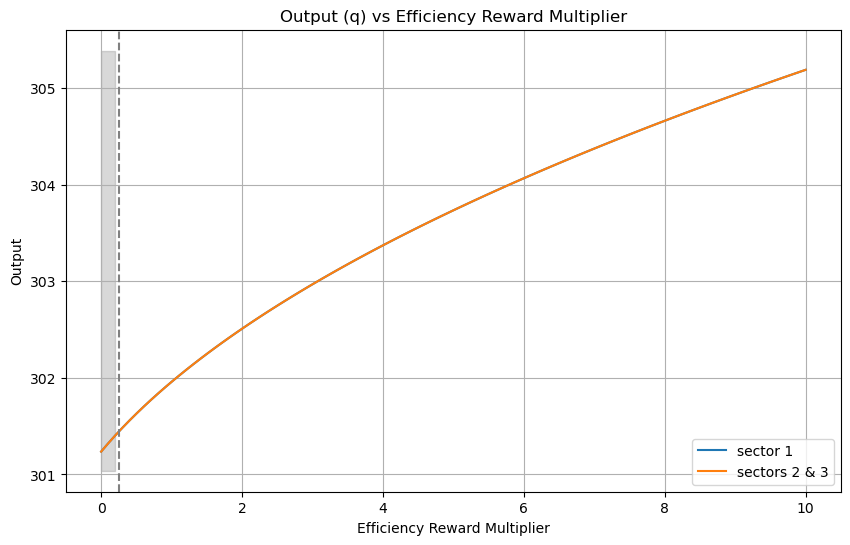

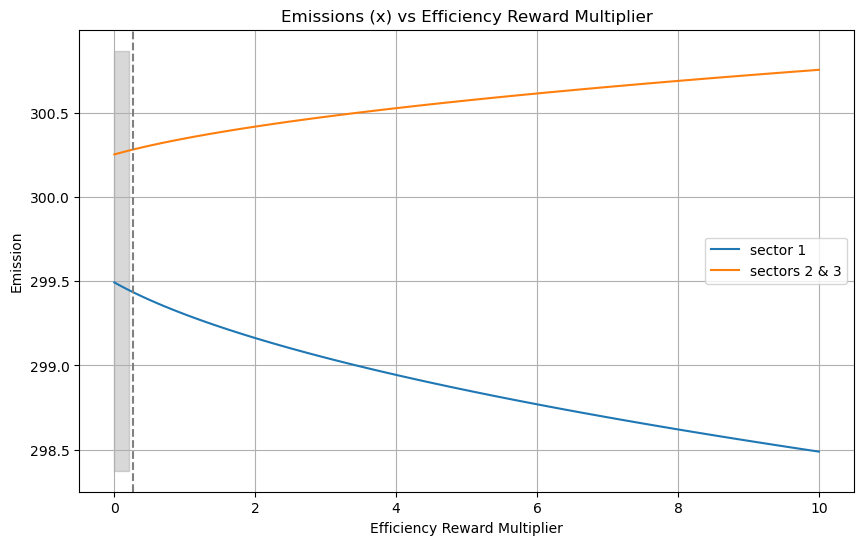

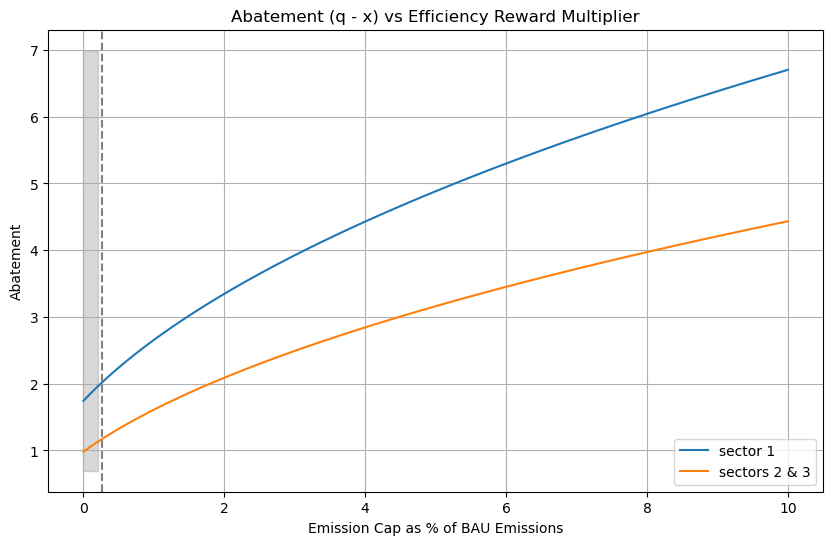

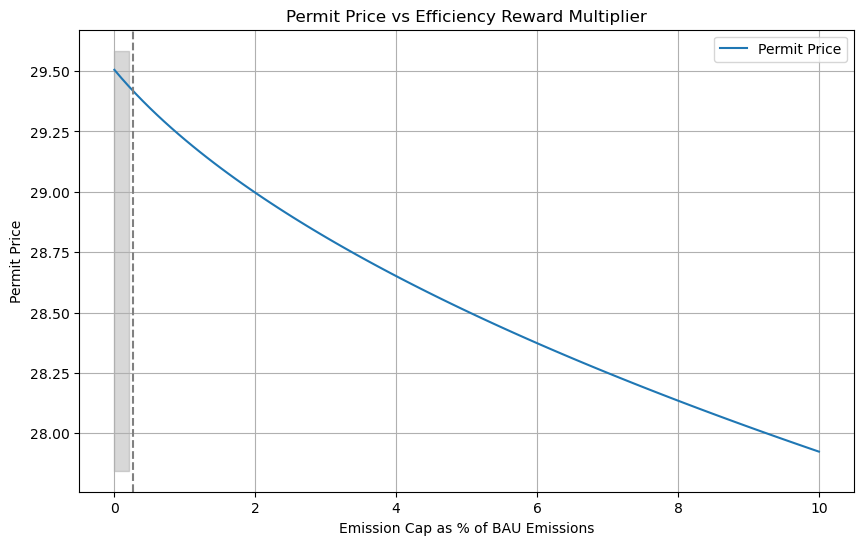

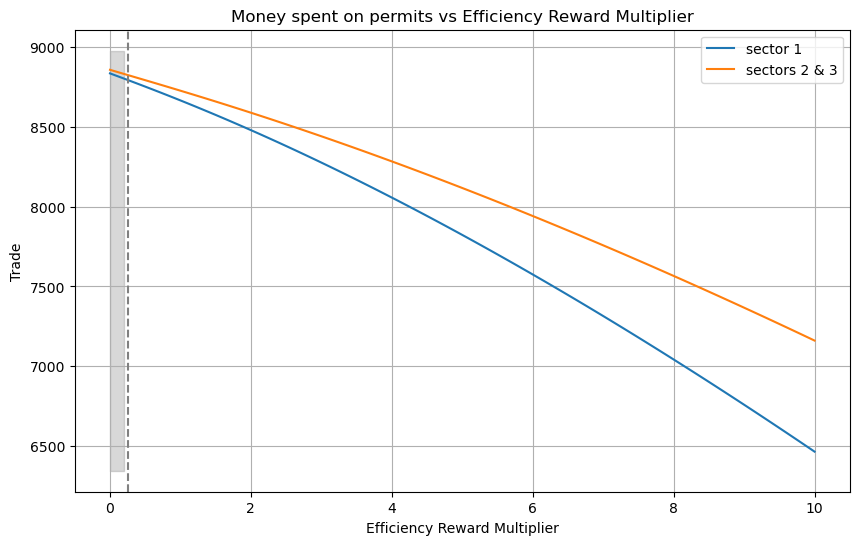

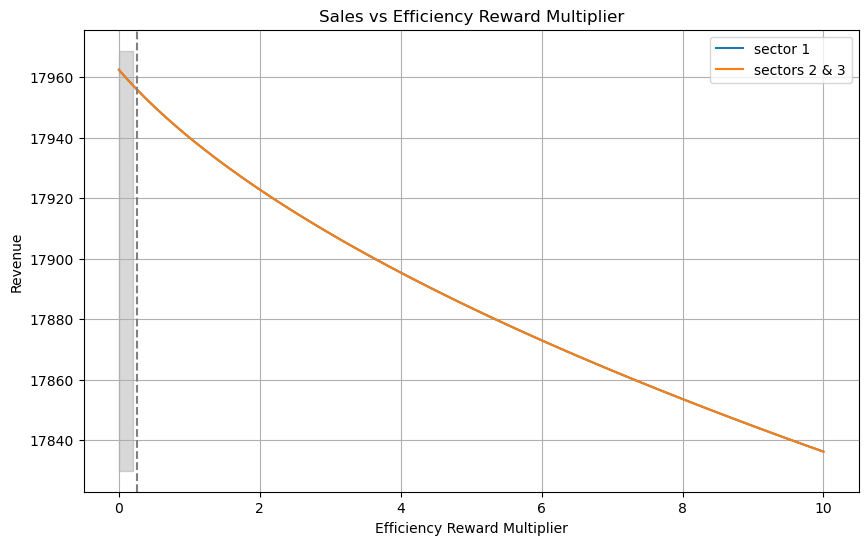

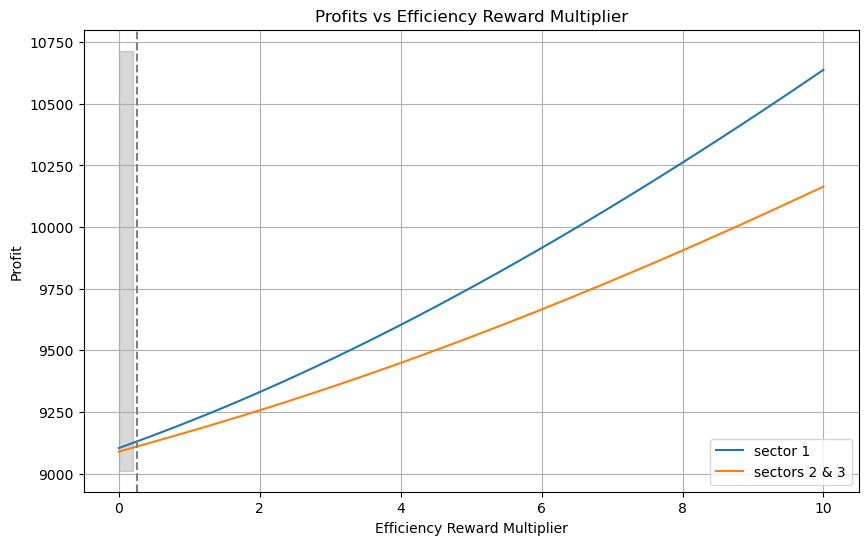

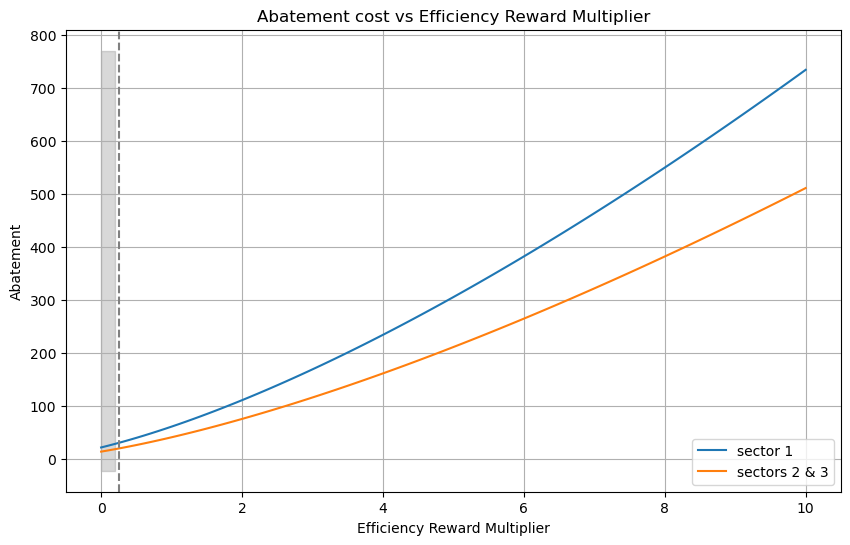

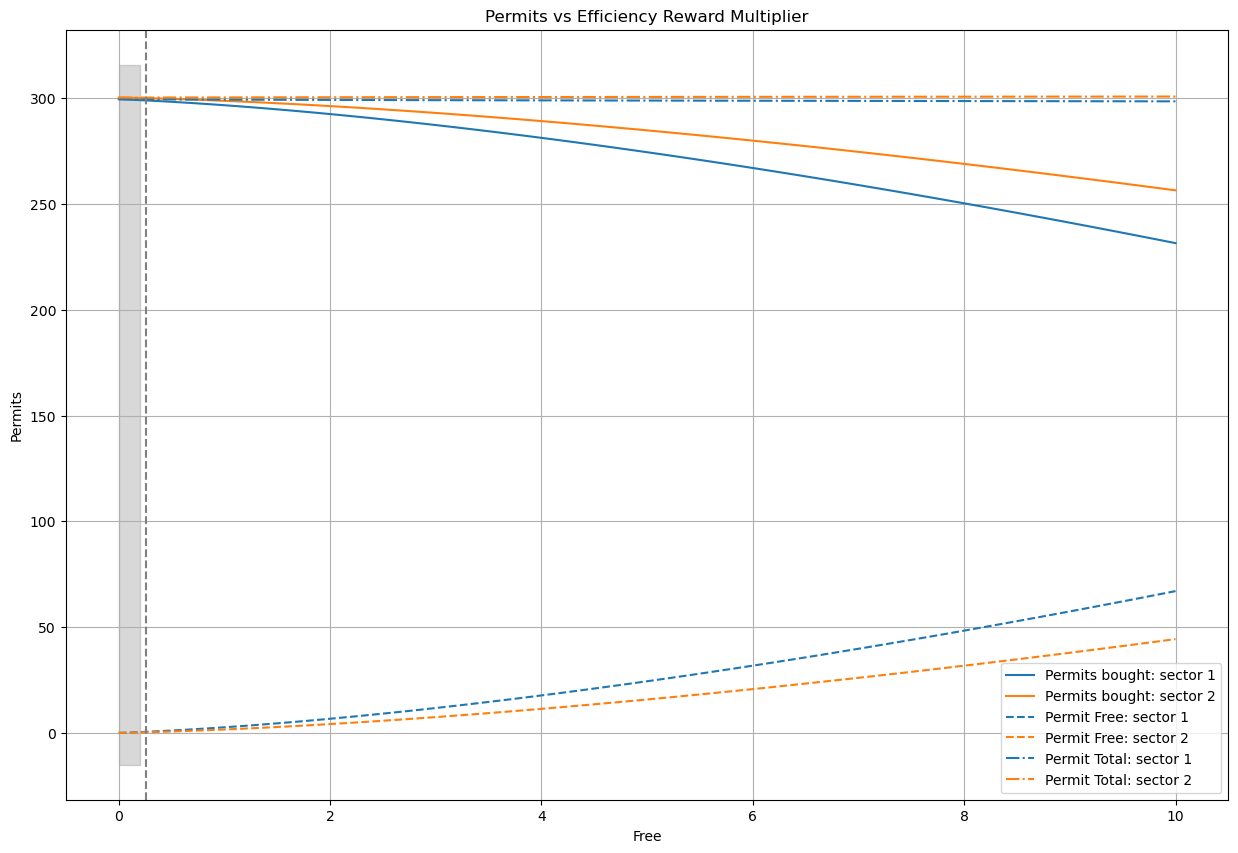

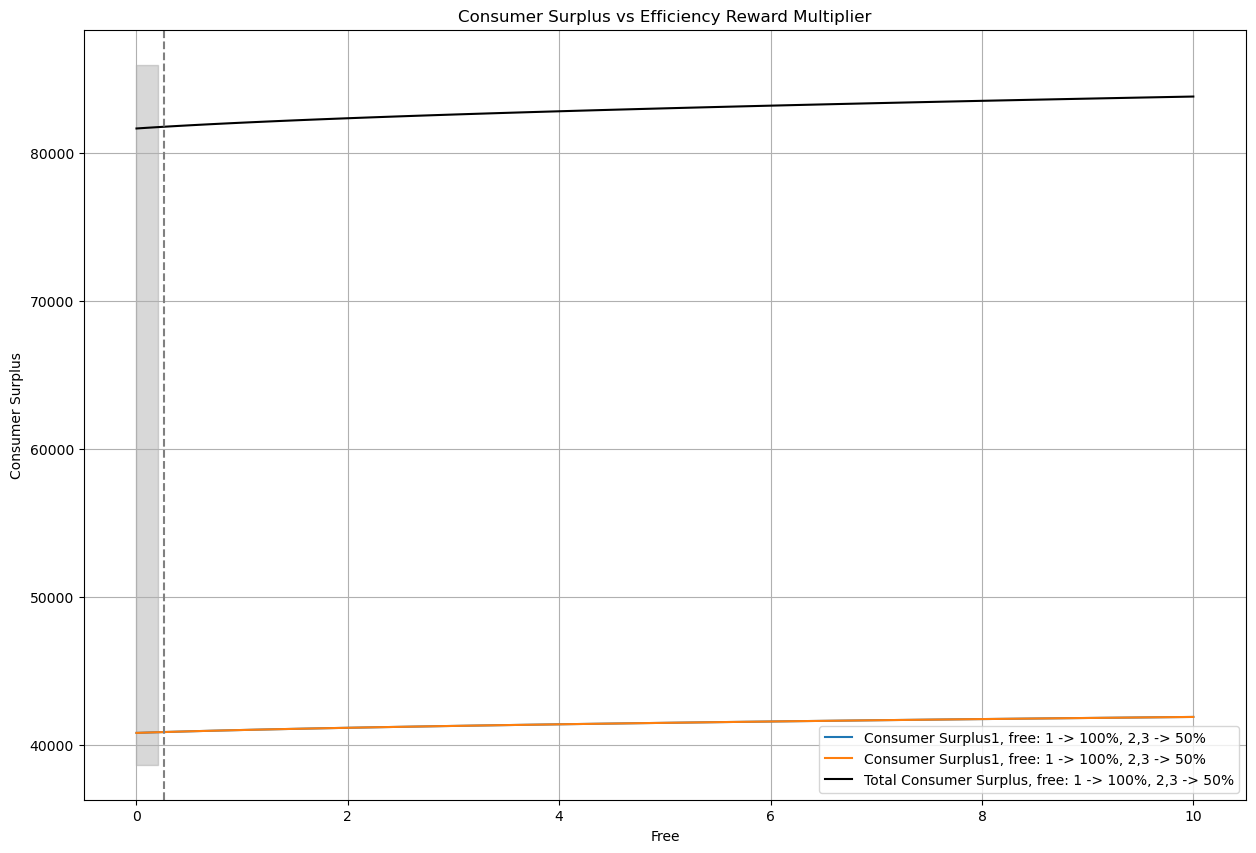

In [11]:
first_value = 0
last_value = 100
# Define colors
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}

last_wrong_value = 0.26

# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees, results[True][f'{metric}1'], label='sector 1', color=colors['trades1'])
    plt.plot(frees, results[True][f'{metric}2'], label='sectors 2 & 3', color=colors['trades2'])
    plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
    plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
    plt.xlabel('Efficiency Reward Multiplier')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Efficiency Reward Multiplier')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emissions (x) vs Efficiency Reward Multiplier')

# Plot the difference output - emission to illustrate the abatement
plt.figure(figsize=(10, 6))
plt.plot(frees, np.array(results[True]['outputs1']) - np.array(results[True]['emissions1']), label='sector 1', color=colors['trades1'])
plt.plot(frees, np.array(results[True]['outputs2']) - np.array(results[True]['emissions2']), label='sectors 2 & 3', color=colors['trades2'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Abatement')
plt.title('Abatement (q - x) vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()

# Plot permit prices
plt.figure(figsize=(10, 6))
plt.plot(frees, results[True]['permit_price'], label='Permit Price', color=colors['trades1'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()


# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Efficiency Reward Multiplier')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Efficiency Reward Multiplier')

# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Efficiency Reward Multiplier')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatement cost vs Efficiency Reward Multiplier')


# Plot permits bought, free, and used for each doentage
alphas = {True: 1, False: 0.5}
colors = {'b': '#1f77b4', 'o': '#ff7f0e'}
plt.figure(figsize=(15, 10))
for do in [True]: plt.plot(frees[first_value:last_value], results[do]['permits_bought_1'][first_value:last_value], label=f'Permits bought: sector 1', color=colors['b'], alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_bought_2'][first_value:last_value], label=f'Permits bought: sector 2', color=colors['o'], alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_free_1'][first_value:last_value], label=f'Permit Free: sector 1', color=colors['b'], linestyle='--', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_free_2'][first_value:last_value], label=f'Permit Free: sector 2', color=colors['o'], linestyle='--', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_used_1'][first_value:last_value], label=f'Permit Total: sector 1', color=colors['b'], linestyle='-.', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_used_2'][first_value:last_value], label=f'Permit Total: sector 2', color=colors['o'], linestyle='-.', alpha=alphas[do])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Permits')
plt.title('Permits vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()



from operator import add
plt.figure(figsize=(15, 10))
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_1'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['b'])
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_2'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['o'])
plt.plot(frees[first_value:last_value], list( map(add,results[True]['consumer_surplus_1'], results[True]['consumer_surplus_2']))[first_value:last_value], label=f'Total Consumer Surplus, free: 1 -> 100%, 2,3 -> 50%', color='black')
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Consumer Surplus')
plt.title('Consumer Surplus vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()